# Imports

In [326]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from datetime import date
from datetime import time
from datetime import timedelta
from shutil import copyfile
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
import numpy as np
import bcolz
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn as sns
import statsmodels.api as sm

# Extend labeled dataset with neighbours

In [4]:
df = pd.read_csv('../data/labels.csv')

In [21]:
def dtfstr(img_name):
    return datetime.strptime(img_name[:-4], '%Y%m%d%H%M%S')


df['dt'] = [dtfstr(img) for img in df.imgs]

entries = [(row.imgs, row.labels, row.labels) for row in df.itertuples()]

for img in os.listdir('../data/all/imgs/'):
    dt = dtfstr(img)
    for row in df.itertuples():
        if abs((row.dt - dt).total_seconds()) < 3 * 60:
            entries.append((img, row.labels, None))

In [ ]:
os.listdir('../data/all/imgs/')

In [22]:
len(entries)

1154

In [33]:
df = pd.DataFrame(entries)
df = df.rename(columns={0: 'img', 1: 'guessed', 2: 'true'})
df = df.sort_values('img')
df.head(n=20)

,img,guessed,true
761,20170906114715.jpg,1,NaN
612,20170906114831.jpg,1,NaN
0,20170906114932.jpg,1,1.0
574,20170906114932.jpg,1,NaN
964,20170906115045.jpg,1,NaN
1027,20170906115200.jpg,1,NaN
728,20170906124116.jpg,2,NaN
830,20170906124230.jpg,2,NaN
1,20170906124345.jpg,2,2.0
698,20170906124345.jpg,2,NaN


In [56]:
df.groupby('img').mean().to_csv('../data/916labels.csv')

In [55]:
df.groupby('img').mean().shape

(916, 2)

In [59]:
os.mkdir('../data/916label')
os.mkdir('../data/916label/imgs')

for img in df.img:
    copyfile(os.path.join('../data/all/imgs', img), os.path.join('../data/916label/imgs', img))
    

Now I should adjust guessed labels by hand

# Calculate ResNet vectors for full dataset

In [63]:
resnet_model = ResNet50(include_top=False, input_shape=(3, 224, 224))

In [65]:
def save_array(fname, arr): 
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname): 
    return bcolz.open(fname)[:]

def save_resnet_vecs(vec_fname, img_name_fname, folder):
    gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    batches = gen.flow_from_directory(folder, 
                                      target_size=(224, 224), 
                                      batch_size=64, 
                                      class_mode=None,
                                      shuffle=False)
    vecs = resnet_model.predict_generator(batches, steps=(batches.samples + batches.batch_size) 
                                          // batches.batch_size)
    save_array(vec_fname, vecs)
    save_array(img_name_fname, batches.filenames)
    
def load_resnet_vecs(vec_fname, img_name_fname):
    return load_array(img_name_fname), load_array(vec_fname)

In [ ]:
save_resnet_vecs('vecs_all', 'img_name_all', '../data/all')

In [66]:
fnames_all, vecs_all = load_resnet_vecs('vecs_all', 'img_name_all')

# Check prediction errors on extended dataset

In [85]:
df = pd.read_csv('../data/916labels.csv')
df = pd.DataFrame({'img': [x[5:] for x in fnames_all], 'vec_id': range(fnames_all.size)}).merge(df, on='img', how='right')

x_train = vecs_all[df.vec_id].reshape(df.shape[0], 2048)
y_train = np.array(df.guessed)
x_train.shape, y_train.shape

((916, 2048), (916,))

In [121]:
regr = linear_model.Lasso(alpha = 0.05)
scores = cross_val_score(regr, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores, np.mean(scores), np.std(scores)

(array([-2.016733  , -1.81555332, -2.09395169, -1.76311397, -1.54601397]),
 -1.8470731895956671,
 0.19411994116942485)

In [122]:
regr = linear_model.Ridge(alpha = 20)
scores = cross_val_score(regr, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores, np.mean(scores), np.std(scores)

(array([-1.62499644, -1.34300947, -1.33450221, -1.09661084, -1.11655137]),
 -1.3031340656270385,
 0.19164255149838783)

In [123]:
regr.fit(x_train, y_train)
mean_squared_error(y_train, regr.predict(x_train))

0.4785786138378586

In [124]:
regr = linear_model.Ridge(alpha = 100)
scores = cross_val_score(regr, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores, np.mean(scores), np.std(scores)

(array([-1.59430975, -1.42208044, -1.47654115, -1.26286993, -1.16232203]),
 -1.3836246606483731,
 0.15366007127160033)

In [125]:
regr.fit(x_train, y_train)
mean_squared_error(y_train, regr.predict(x_train))

0.87106253695792513

# Check couple of extreme errors

# Check predictions

In [150]:
regr = linear_model.Ridge(alpha = 100)
regr.fit(x_train[:-100], y_train[:-100])

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [151]:
preds = regr.predict(x_train[-100:])
mean_squared_error(y_train[-100:], preds)

0.97372073098189693

In [152]:
subdf = df[-100:].copy()
subdf['preds'] = preds
subdf['error'] = subdf.preds - subdf.guessed

Top two overestimated:

In [154]:
subdf.sort_values('error', ascending=False).head(n=2)

,img,vec_id,guessed,true,preds,error
828,20170907185330.jpg,7207,3.0,NaN,5.834606,2.834606
884,20170908145531.jpg,7719,2.0,NaN,3.914551,1.914551


![title](../data/all/imgs/20170907185330.jpg)

![title](../data/all/imgs/20170908145531.jpg)

Top two underestimated:

In [156]:
subdf.sort_values('error', ascending=True).head(n=2)

,img,vec_id,guessed,true,preds,error
854,20170922165930.jpg,7329,9.0,NaN,5.827206,-3.172794
867,20170912150945.jpg,7512,6.0,NaN,3.006664,-2.993336


![title](../data/all/imgs/20170922165930.jpg)

![title](../data/all/imgs/20170912150945.jpg)

# Check error when averaging close in time predictions

In [157]:
regr = linddear_model.Ridge(alpha = 100)
regr.fit(x_train[:-200], y_train[:-200])

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [158]:
preds = regr.predict(x_train[-200:])
mean_squared_error(y_train[-200:], preds)

1.2349057764031195

In [172]:
def check_error_for_averaging(minutes):
    subdf = df[-200:].copy()
    subdf['preds'] = preds
    subdf['datetime'] = [dtfstr(x) for x in subdf.img]

    new_preds = []
    for row in subdf.itertuples():
        new_preds.append(subdf[[abs((dt - row.datetime).total_seconds()) <= 60 * minutes 
                                for dt in subdf.datetime]].preds.mean())
    return mean_squared_error(y_train[-200:], new_preds)

In [176]:
(check_error_for_averaging(1), 
 check_error_for_averaging(2), 
 check_error_for_averaging(3), 
 check_error_for_averaging(4), 
 check_error_for_averaging(5), 
 check_error_for_averaging(6), 
 check_error_for_averaging(7),
 check_error_for_averaging(8),
 check_error_for_averaging(9),
 check_error_for_averaging(10),
 check_error_for_averaging(11),
 check_error_for_averaging(12),
 check_error_for_averaging(13),
 check_error_for_averaging(14),
 check_error_for_averaging(15))

(1.2349057764031195,
 1.2021324887303326,
 1.1244257672219686,
 1.1101680478117157,
 1.1106489541716036,
 1.1037024012787022,
 1.1070299417147793,
 1.0985795877884967,
 1.0988960619291506,
 1.1022431644386268,
 1.1077874673847976,
 1.1417548402759459,
 1.1511941308687204,
 1.1911307948364251,
 1.201556714887217)

In [177]:
regr = linear_model.Ridge(alpha = 100)
regr.fit(x_train, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [179]:
preds = regr.predict(vecs_all.reshape(vecs_all.shape[0], 2048))

In [445]:
df = pd.DataFrame({'datetime': [dtfstr(x[5:]).replace(second=0) for x in fnames_all], 'swimmers': preds}, 
                  index=[dtfstr(x[5:]).replace(second=0) for x in fnames_all])
df = df.sort_index(axis=0)
df.head(n=10)

,datetime,swimmers
2017-09-06 11:47:00,2017-09-06 11:47:00,-0.256686
2017-09-06 11:48:00,2017-09-06 11:48:00,-0.063244
2017-09-06 11:49:00,2017-09-06 11:49:00,-0.080745
2017-09-06 11:50:00,2017-09-06 11:50:00,0.193153
2017-09-06 11:52:00,2017-09-06 11:52:00,0.106458
2017-09-06 11:53:00,2017-09-06 11:53:00,-0.577290
2017-09-06 11:55:00,2017-09-06 11:55:00,-0.339471
2017-09-06 11:56:00,2017-09-06 11:56:00,0.720139
2017-09-06 11:57:00,2017-09-06 11:57:00,1.236818
2017-09-06 12:00:00,2017-09-06 12:00:00,1.448742


# Predict for whole dataset

# Analysis

In [252]:
df['hour'] = df.dt.dt.hour
df['weekday'] = df.dt.dt.weekday
df['dayofyear'] = df.dt.dt.dayofyear
df['minofday'] = df.dt.dt.hour * 60 + df.dt.dt.minute

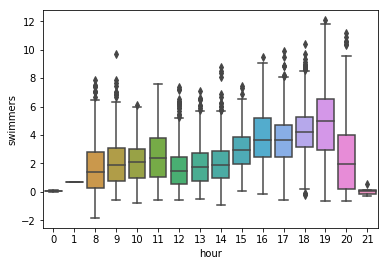

In [253]:
sns.boxplot(x="hour", y="swimmers", data=df)

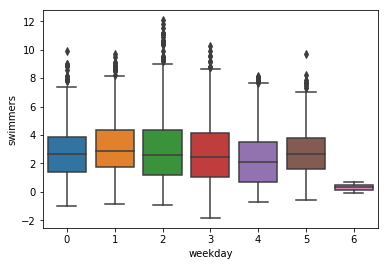

In [254]:
sns.boxplot(x="weekday", y="swimmers", data=df)

In [255]:
df.dt.dt.dayofyear.unique()

array([249, 250, 251, 252, 253, 254, 255, 256, 257, 259, 261, 262, 263,
       264, 265, 266, 267])

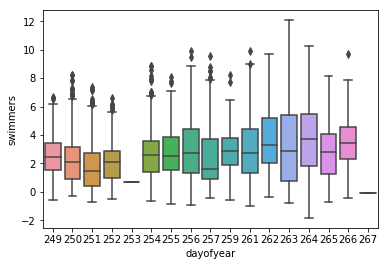

In [256]:
sns.boxplot(x="dayofyear", y="swimmers", data=df)

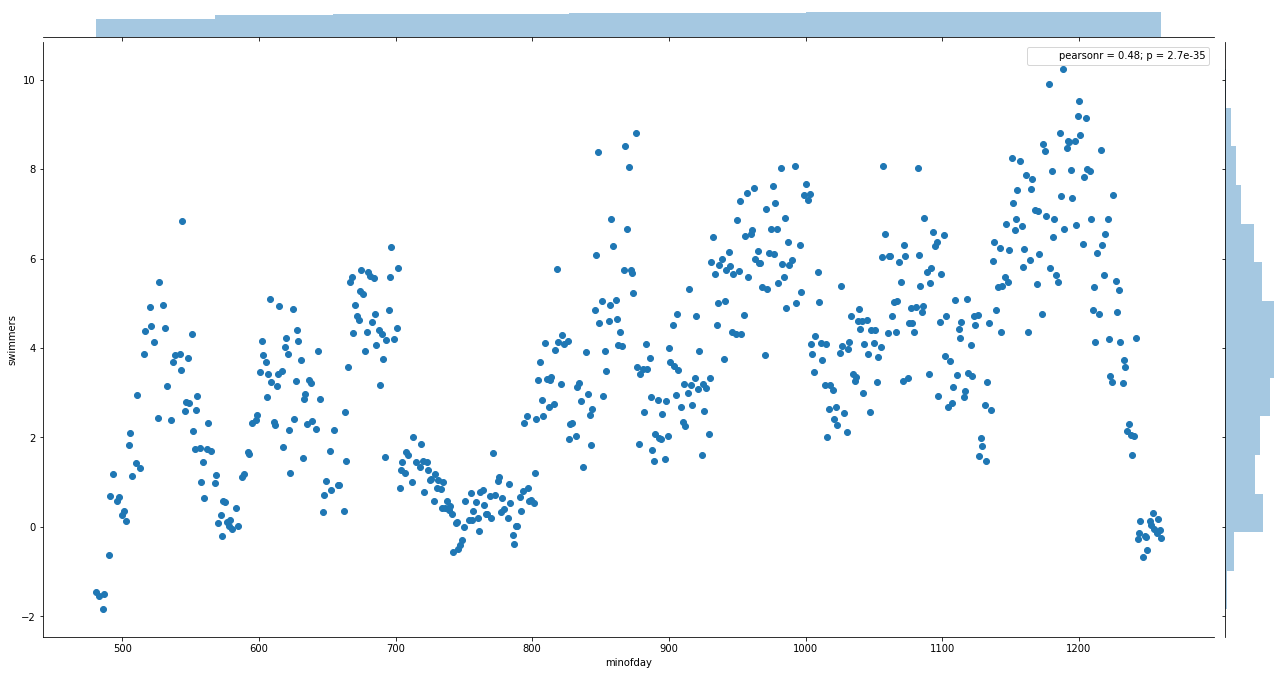

In [257]:
df['minofday'] = df.dt.dt.hour * 60 + df.dt.dt.minute
p = sns.jointplot('minofday', 'swimmers', df[df.dt.dt.day == 21], ratio=19)
p.fig.set_size_inches(20,10)

In [297]:
ts = df['swimmers'].asfreq('Min')

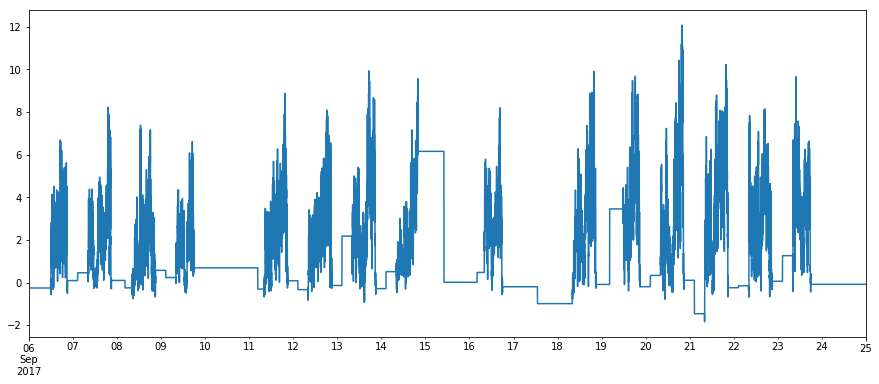

In [298]:
ts.plot(figsize=(15, 6))
plt.show()

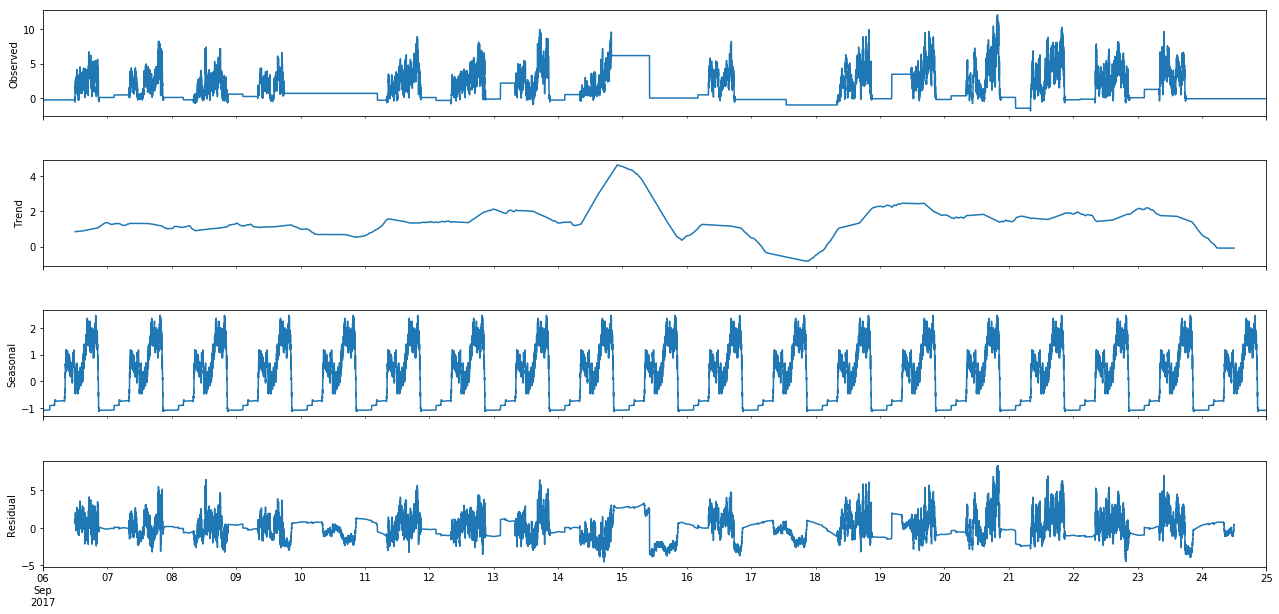

In [311]:
decomposition = sm.tsa.seasonal_decompose(ts, model='additive', freq=1440)
fig = decomposition.plot()
fig.set_size_inches(20,10)
plt.show()

In [317]:
for i in range(6, 25):
    print(df[df.datetime.dt.day == i].datetime.min(), df[df.datetime.dt.day == i].datetime.max())

2017-09-06 11:47:00 2017-09-06 21:00:00
2017-09-07 08:01:00 2017-09-07 21:57:00
2017-09-08 00:39:00 2017-09-08 21:00:00
2017-09-09 08:02:00 2017-09-09 18:00:00
2017-09-10 11:06:00 2017-09-10 11:06:00
2017-09-11 01:17:00 2017-09-11 21:00:00
2017-09-12 08:02:00 2017-09-12 21:00:00
2017-09-13 08:01:00 2017-09-13 21:01:00
2017-09-14 08:01:00 2017-09-14 19:55:00
NaT NaT
2017-09-16 00:14:00 2017-09-16 18:00:00
NaT NaT
2017-09-18 08:02:00 2017-09-18 21:01:00
2017-09-19 11:40:00 2017-09-19 21:00:00
2017-09-20 08:02:00 2017-09-20 21:00:00
2017-09-21 08:01:00 2017-09-21 21:00:00
2017-09-22 08:01:00 2017-09-22 21:00:00
2017-09-23 08:01:00 2017-09-23 17:59:00
2017-09-24 14:01:00 2017-09-24 14:01:00


In [437]:
d = df.index.min().date()
stop = (df.index.max() + timedelta(1)).date()
d, stop
minutes = []
while d < stop:
    if d == date(2017, 9, 15):
        d = d + timedelta(1)
        continue
    t = datetime.combine(d, time(8, 0))
    stop_t = datetime.combine(d, time(21, 0))
    while t < stop_t:
        minutes.append(t)
        t = t + timedelta(0, 60)
    d = d + timedelta(1)
minutes

[datetime.datetime(2017, 9, 6, 8, 0),
 datetime.datetime(2017, 9, 6, 8, 1),
 datetime.datetime(2017, 9, 6, 8, 2),
 datetime.datetime(2017, 9, 6, 8, 3),
 datetime.datetime(2017, 9, 6, 8, 4),
 datetime.datetime(2017, 9, 6, 8, 5),
 datetime.datetime(2017, 9, 6, 8, 6),
 datetime.datetime(2017, 9, 6, 8, 7),
 datetime.datetime(2017, 9, 6, 8, 8),
 datetime.datetime(2017, 9, 6, 8, 9),
 datetime.datetime(2017, 9, 6, 8, 10),
 datetime.datetime(2017, 9, 6, 8, 11),
 datetime.datetime(2017, 9, 6, 8, 12),
 datetime.datetime(2017, 9, 6, 8, 13),
 datetime.datetime(2017, 9, 6, 8, 14),
 datetime.datetime(2017, 9, 6, 8, 15),
 datetime.datetime(2017, 9, 6, 8, 16),
 datetime.datetime(2017, 9, 6, 8, 17),
 datetime.datetime(2017, 9, 6, 8, 18),
 datetime.datetime(2017, 9, 6, 8, 19),
 datetime.datetime(2017, 9, 6, 8, 20),
 datetime.datetime(2017, 9, 6, 8, 21),
 datetime.datetime(2017, 9, 6, 8, 22),
 datetime.datetime(2017, 9, 6, 8, 23),
 datetime.datetime(2017, 9, 6, 8, 24),
 datetime.datetime(2017, 9, 6, 8, 2

/home/nighturs/Projects/swimmingpool-ipcam-analysis/env/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


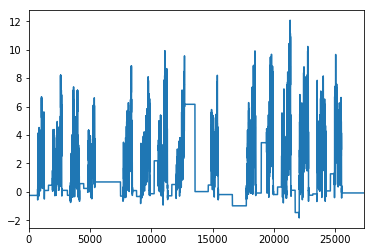

In [290]:
sns.tsplot(df['swimmers'])

In [360]:
len(minutes)

14040

In [361]:
df = df.reindex(minutes, method='nearest')
df['datetime'] = df.index
df.head()

,datetime,swimmers
2017-09-06 08:00:00,2017-09-06 08:00:00,-0.256686
2017-09-06 08:01:00,2017-09-06 08:01:00,-0.256686
2017-09-06 08:02:00,2017-09-06 08:02:00,-0.256686
2017-09-06 08:03:00,2017-09-06 08:03:00,-0.256686
2017-09-06 08:04:00,2017-09-06 08:04:00,-0.256686


In [363]:
wd = df[df.datetime.dt.dayofweek < 5]
wd.index = pd.date_range(datetime(2000, 1, 1), datetime(2000, 1, 1) + timedelta(0, 9360 - 1), freq='S')
wd.head()

,datetime,swimmers
2000-01-01 00:00:00,2017-09-06 08:00:00,-0.256686
2000-01-01 00:00:01,2017-09-06 08:01:00,-0.256686
2000-01-01 00:00:02,2017-09-06 08:02:00,-0.256686
2000-01-01 00:00:03,2017-09-06 08:03:00,-0.256686
2000-01-01 00:00:04,2017-09-06 08:04:00,-0.256686


In [364]:
wd.shape[0] 

9360

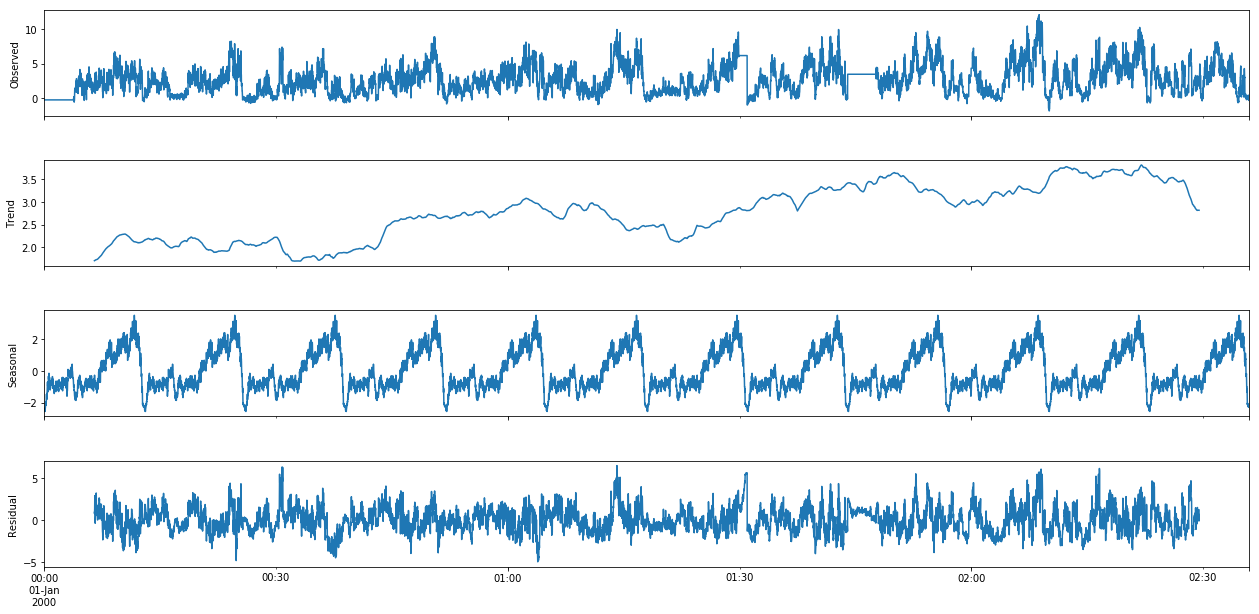

In [365]:
decomposition = sm.tsa.seasonal_decompose(wd['swimmers'], model='additive', freq=13 * 60)
fig = decomposition.plot()
fig.set_size_inches(20,10)
plt.show()

In [366]:
wd10 = wd.resample('10S').mean()
wd10.shape

(936, 1)

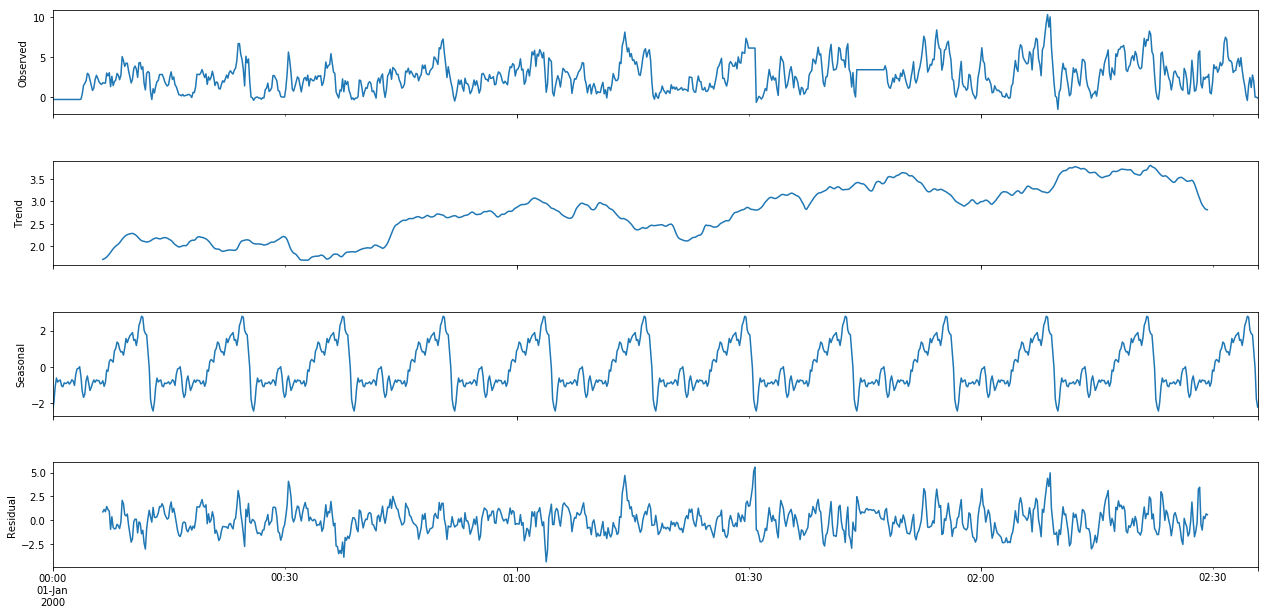

In [372]:
decomposition = sm.tsa.seasonal_decompose(wd10['swimmers'], model='additive', freq=13 * 6)
fig = decomposition.plot()
fig.set_size_inches(20,10)
plt.show()

In [368]:
decomposition.seasonal

2000-01-01 00:00:00   -2.438966
2000-01-01 00:00:10   -1.959943
2000-01-01 00:00:20   -1.113781
2000-01-01 00:00:30   -0.620042
2000-01-01 00:00:40   -0.840548
2000-01-01 00:00:50   -0.762738
2000-01-01 00:01:00   -0.725682
2000-01-01 00:01:10   -1.052229
2000-01-01 00:01:20   -1.100454
2000-01-01 00:01:30   -0.888982
2000-01-01 00:01:40   -0.924849
2000-01-01 00:01:50   -0.893273
2000-01-01 00:02:00   -0.826759
2000-01-01 00:02:10   -0.954622
2000-01-01 00:02:20   -0.871691
2000-01-01 00:02:30   -0.713436
2000-01-01 00:02:40   -0.785648
2000-01-01 00:02:50   -1.028103
2000-01-01 00:03:00   -0.411599
2000-01-01 00:03:10   -0.118023
2000-01-01 00:03:20   -0.088384
2000-01-01 00:03:30    0.004311
2000-01-01 00:03:40   -0.519075
2000-01-01 00:03:50   -1.345462
2000-01-01 00:04:00   -1.685881
2000-01-01 00:04:10   -1.524522
2000-01-01 00:04:20   -0.759038
2000-01-01 00:04:30   -0.503516
2000-01-01 00:04:40   -0.900505
2000-01-01 00:04:50   -1.303658
                         ...   
2000-01-

In [388]:
decomposition.seasonal[:13 * 6]

hits = {}
for i, x in enumerate(decomposition.resid):
    if pd.isnull(x):
        continue
    ind = i % (13 * 6)
    if not ind in hits:
        hits[ind]=[x]
    else:
        hits[ind].append(x)
        
hits

{0: [1.3602109988019135,
  0.014970572217790856,
  0.26248585503831912,
  -0.69400927376052879,
  0.90870114464262119,
  0.52842895104570697,
  -0.98278015975532984,
  2.476979423033951,
  0.24338011113493963,
  -2.5754613054926119,
  -1.4835058112256538],
 1: [0.34294616227549679,
  -0.19341966887591666,
  -0.0061881289004470652,
  -0.56149850244122423,
  1.2587693826702406,
  -0.42488129712058087,
  -1.0854546050707266,
  1.9943253447326568,
  0.37122997279312853,
  -0.98985108250073384,
  -0.64657707188077462],
 2: [0.29409076699992709,
  -0.91033679085419794,
  -0.87079252980548261,
  -0.47972991253936192,
  1.0394397417757373,
  -1.4775433727892928,
  -1.5719645559543605,
  1.1572990646400128,
  1.3547559796073687,
  -1.4689724894736631,
  2.9931546040744337],
 3: [0.39982905085783882,
  -1.3874574141506413,
  -1.1855236495965589,
  0.16476064824654602,
  0.075750241196860468,
  -1.2855881543329724,
  -2.2275840548393653,
  0.67785621921353023,
  2.1780616460366877,
  -0.060948106

In [ ]:
dt = df.index.min().replace(hour=0, minute=0, second=0)
stop = (df.index.max() + timedelta(1)).replace(hour=0, minute=0, second=0)
minutes = []
while dt <= stop:
    minutes.append(dt)
    dt = dt + timedelta(0, 60)
df = df.reindex(minutes, method='nearest')
df['datetime'] = df.index
df

In [433]:
plot_dt = pd.DataFrame({'min': ['{}:{}'.format(8 + x // 6, 10 * (x % 6)) for x in range(13 * 6)], 
              'seas': decomposition.seasonal[:13 * 6].as_matrix(), 
              'low': [decomposition.seasonal[x] + np.min(hits[x]) for x in range(13 * 6)],
              'high': [decomposition.seasonal[x] + np.max(hits[x]) for x in range(13 * 6)]}, index=range(13 * 6))
plot_dt.head()

,high,low,min,seas
0,0.038013,-5.014428,8:0,-2.438966
1,0.034382,-3.045398,8:10,-1.959943
2,1.879374,-2.685745,8:20,-1.113781
3,2.090202,-2.847626,8:30,-0.620042
4,0.599896,-3.074454,8:40,-0.840548


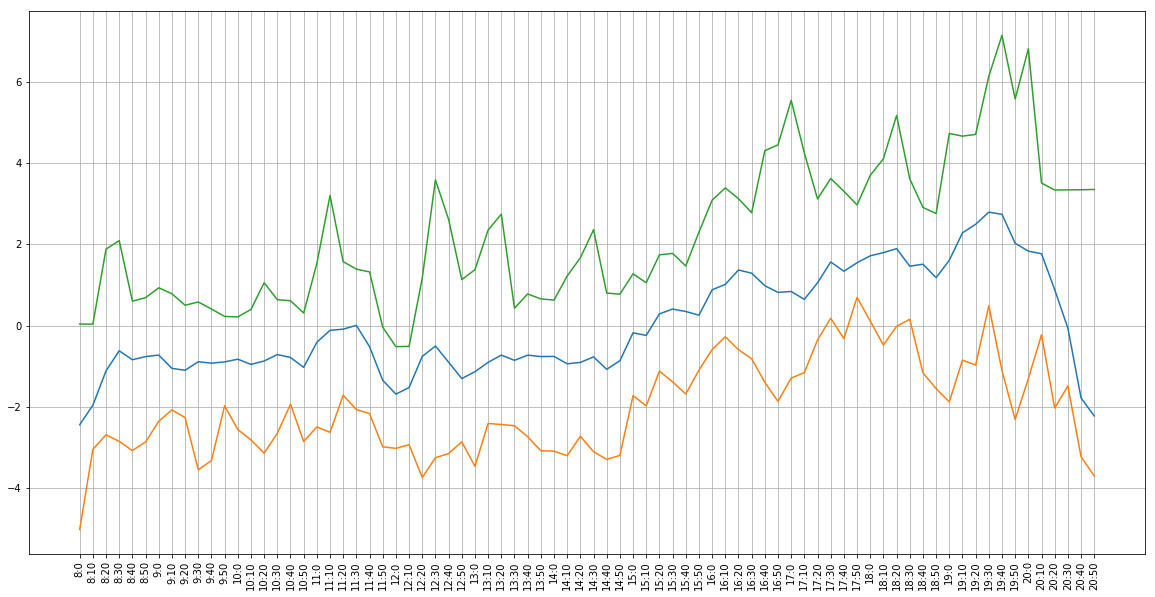

In [435]:
fig, ax = plt.subplots(1,1) 
fig.set_size_inches(20,10)
ax.plot(plot_dt['seas'])
ax.plot(plot_dt['low'])
ax.plot(plot_dt['high'])
ax.set_xticks(range(len(plot_dt['high'])))
ax.set_xticklabels(plot_dt['min'], rotation='vertical', fontsize=10)
plt.grid()
plt.show()


In [446]:
d = df.index.min().date()
stop = (df.index.max() + timedelta(1)).date()
d, stop
minutes = []
while d < stop:
    if d == date(2017, 9, 15):
        d = d + timedelta(1)
        continue
    t = datetime.combine(d, time(8, 0))
    stop_t = datetime.combine(d, time(18, 0))
    while t < stop_t:
        minutes.append(t)
        t = t + timedelta(0, 60)
    d = d + timedelta(1)
minutes

[datetime.datetime(2017, 9, 6, 8, 0),
 datetime.datetime(2017, 9, 6, 8, 1),
 datetime.datetime(2017, 9, 6, 8, 2),
 datetime.datetime(2017, 9, 6, 8, 3),
 datetime.datetime(2017, 9, 6, 8, 4),
 datetime.datetime(2017, 9, 6, 8, 5),
 datetime.datetime(2017, 9, 6, 8, 6),
 datetime.datetime(2017, 9, 6, 8, 7),
 datetime.datetime(2017, 9, 6, 8, 8),
 datetime.datetime(2017, 9, 6, 8, 9),
 datetime.datetime(2017, 9, 6, 8, 10),
 datetime.datetime(2017, 9, 6, 8, 11),
 datetime.datetime(2017, 9, 6, 8, 12),
 datetime.datetime(2017, 9, 6, 8, 13),
 datetime.datetime(2017, 9, 6, 8, 14),
 datetime.datetime(2017, 9, 6, 8, 15),
 datetime.datetime(2017, 9, 6, 8, 16),
 datetime.datetime(2017, 9, 6, 8, 17),
 datetime.datetime(2017, 9, 6, 8, 18),
 datetime.datetime(2017, 9, 6, 8, 19),
 datetime.datetime(2017, 9, 6, 8, 20),
 datetime.datetime(2017, 9, 6, 8, 21),
 datetime.datetime(2017, 9, 6, 8, 22),
 datetime.datetime(2017, 9, 6, 8, 23),
 datetime.datetime(2017, 9, 6, 8, 24),
 datetime.datetime(2017, 9, 6, 8, 2

In [447]:
df = df.reindex(minutes, method='nearest')
df['datetime'] = df.index
df.size

21600

In [449]:
hd = df[df.datetime.dt.dayofweek == 5]
hd.index = pd.date_range(datetime(2000, 1, 1), datetime(2000, 1, 1) + timedelta(0, hd.shape[0] - 1), freq='S')
hd.head()

,datetime,swimmers
2000-01-01 00:00:00,2017-09-09 08:00:00,0.234599
2000-01-01 00:00:01,2017-09-09 08:01:00,0.234599
2000-01-01 00:00:02,2017-09-09 08:02:00,0.234599
2000-01-01 00:00:03,2017-09-09 08:03:00,-0.042145
2000-01-01 00:00:04,2017-09-09 08:04:00,1.473047


In [450]:
hd10 = hd.resample('10S').mean()
hd10.shape

(180, 1)

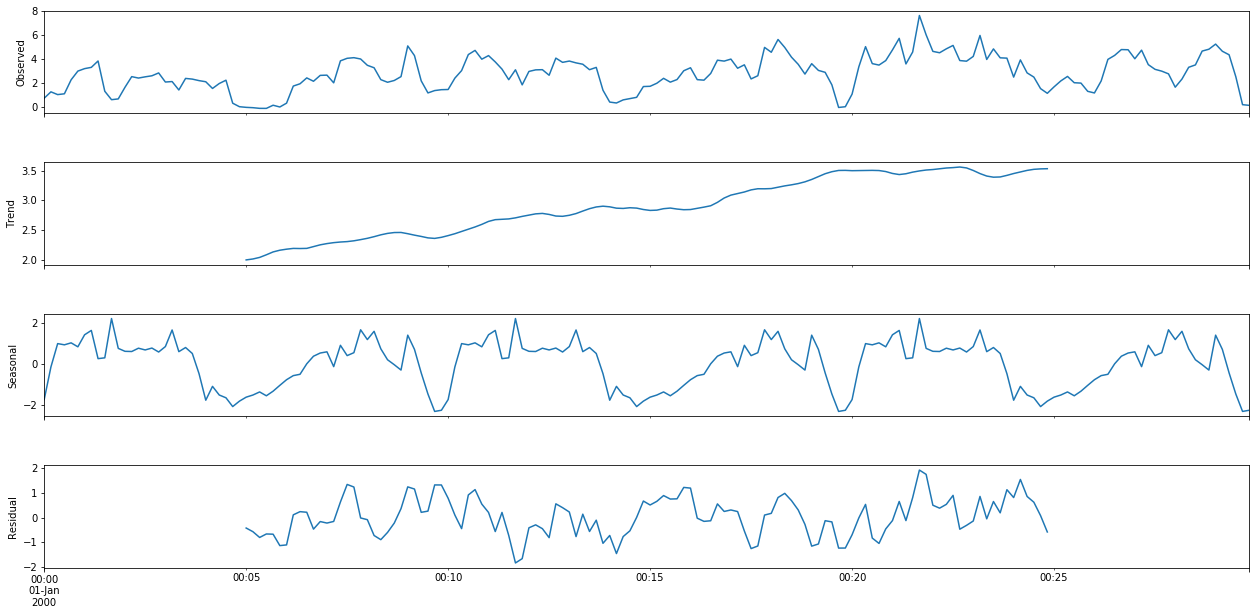

In [452]:
decomposition = sm.tsa.seasonal_decompose(hd10['swimmers'], model='additive', freq=10 * 6)
fig = decomposition.plot()
fig.set_size_inches(20,10)
plt.show()

In [453]:
plot_dt = pd.DataFrame({'min': ['{}:{}'.format(8 + x // 6, 10 * (x % 6)) for x in range(13 * 6)], 
              'seas': decomposition.seasonal[:13 * 6].as_matrix(), 
              'low': [decomposition.seasonal[x] + np.min(hits[x]) for x in range(13 * 6)],
              'high': [decomposition.seasonal[x] + np.max(hits[x]) for x in range(13 * 6)]}, index=range(13 * 6))
plot_dt.head()

,high,low,min,seas
0,0.726802,-4.325639,8:0,-1.750178
1,1.844709,-1.235071,8:10,-0.149616
2,3.987073,-0.578046,8:20,0.993918
3,3.644876,-1.292953,8:30,0.934631
4,2.471289,-1.203061,8:40,1.030845


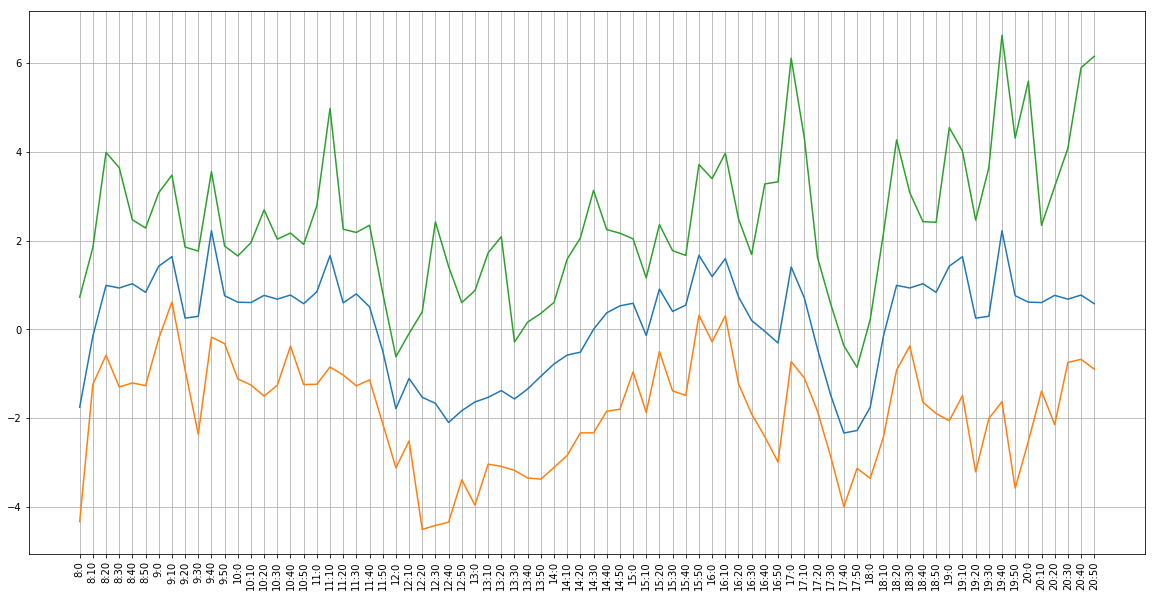

In [454]:
fig, ax = plt.subplots(1,1) 
fig.set_size_inches(20,10)
ax.plot(plot_dt['seas'])
ax.plot(plot_dt['low'])
ax.plot(plot_dt['high'])
ax.set_xticks(range(len(plot_dt['high'])))
ax.set_xticklabels(plot_dt['min'], rotation='vertical', fontsize=10)
plt.grid()
plt.show()